In [2]:
import pandas as pd
import plotly.express as px
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
plt.style.use('./mesa.mplstyle10')

In [5]:
def Fryer_delayed(Mco, Mfinal):
    # --------------- calculate mass of the proto NS Mproto --------------
    if Mco < 3.5:
        Mproto = 1.2
    elif Mco >= 3.5 and Mco < 6: 
        Mproto = 1.3
    elif Mco >= 6. and Mco < 11.:
        Mproto = 1.4
    else:
        Mproto = 1.6
        
    a2 = 0.133 - (0.093/(Mfinal - Mproto))
    b2 = -11*a2 + 1
    # --------------- calculate the amount of fallback onto the compact remnant ----------------    
    if Mco < 2.5:
        Mfb = 0.2
    elif Mco >= 2.5 and Mco <3.5:
        Mfb = 0.5*Mco - 1.05
    elif Mco >= 3.5 and Mco < 11:
        fb = a2*Mco + b2
        Mfb = fb*(Mfinal - Mproto)
    else:
        fb = 1.
        Mfb = fb*(Mfinal - Mproto)

    # -------------- calculate the final baryonic mass of the compact remnant --------------------
    Mrem_b = Mproto + Mfb
    
    return 0.9*Mrem_b   #returns the gravitational mass of the BH

In [6]:
# This concatenates the data into one single file 
dirs = ['fiducial']
subdirs = ['MAD', 'NTD', 'Nonrel_MAD', 'Nonrel_NTD']

for d in dirs:
    for sd in subdirs:
        file = f'./data/{d}/{sd}/'
        symlink = [150, 300, 450, 600, 750, 911]#, 1100, 1250, 1439]
        cols = ['Mexp', 'AMexp', 'Mbh', 'abh', 'Rexp']
        out_data = []

        df_0 = pd.read_csv(file + f'Run_data_{symlink[0]}.txt', delim_whitespace = True)
        for Z in range(len(symlink) - 1):
            df_1 = pd.read_csv(file + f'Run_data_{symlink[Z+1]}.txt',  delim_whitespace = True)
        #     out_data.append(df['Mexp'].values, )
            df_0 = pd.concat([df_0, df_1], axis=0, ignore_index=True)


        df_0.to_csv(f'./data/{d}/{sd}/concatenated_file_{sd}.csv', index=False)

In [8]:
# Loading data 
d = 'fiducial'
dataMAD = pd.read_csv(f'./data/{d}/MAD/concatenated_file_MAD.csv')
dataNT = pd.read_csv(f'./data/{d}/NTD/concatenated_file_NTD.csv')
datanonrel_MAD = pd.read_csv(f'./data/{d}/Nonrel_MAD/concatenated_file_Nonrel_MAD.csv')
datanonrel_NT = pd.read_csv(f'./data/{d}/Nonrel_NTD/concatenated_file_Nonrel_NTD.csv')
dataMAD.head(2)    

,Mbh,abh,AMexp,Mexp,filename,tff,Md,Mco,Rexp,MHe_form,...,MHe_dep,AMfinal_He_dep,R_He_dep,Omega_mean_He_dep,Omega_mean_exp,Mc12_dep,AM_c12_dep,R_c12_dep,Omega_c12_dep,Eacc
0,4.984,0.1515,3.256000e+49,4.984222,0/LOGS/profile72,970.882882,5.113000e-09,2.970036,1.400817,4.999526,...,4.989663,3.300000e+49,1.453448,0.000259,0.000877,4.984223,3.256000e+49,1.453448,0.000259,8.572000e+47
1,8.938,0.1120,7.782000e+49,8.938068,2/LOGS/profile35,0.000000,0.000000e+00,6.534862,1.206268,8.998252,...,8.955658,7.956000e+49,1.206268,0.000181,0.000785,8.938069,7.782000e+49,1.206268,0.000181,0.000000e+00


### Plotting

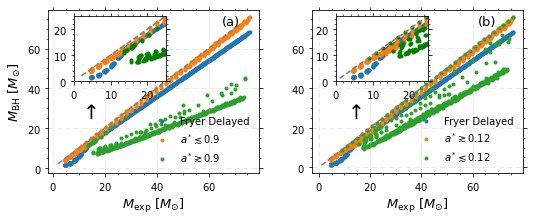

In [10]:
plt.figure(figsize = (8.5,3))
gs = GridSpec(1, 2, wspace = 0.25)

plt.subplot(gs[0])

### --------------------- Calculating remnant masss from Fryer method ---------------------
MBH_Fryer = []
for i in range(len(dataNT)):
    MBH = Fryer_delayed(dataNT.loc[i,'Mco'], dataNT.loc[i,'Mexp'])
    MBH_Fryer.append(MBH)
plt.scatter(dataNT['Mexp'], MBH_Fryer)#, z='Mbh')


# --------------------- Plotting fits for the Novikov-Thorne formalism ----------------------
mask = dataNT["abh"] <=.9  # when spin is lower than aBH < 0.9
# mask1 = dataNT[mask]['Mbh'] / dataNT[mask]['Mexp'] < 1 
plt.scatter(dataNT[mask]['Mexp'], dataNT[mask]['Mbh'])#, z='Mbh')

mask = dataNT["abh"] > .9   # when spin is lower than aBH > 0.9 (this is the green branch in the figure)
plt.scatter(dataNT[mask]['Mexp'], dataNT[mask]['Mbh'])#, z='Mbh')

plt.text(65, 72, '(a)')
plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}]$')
plt.ylabel('$M_{\\rm BH} \,\, [M_{\\odot}]$')
plt.text(10, 25, '$\\uparrow$', fontsize = 20)
plt.legend(['Fryer Delayed', '$a^* \\lesssim \\, 0.9$', '$a^* \\gtrsim \\, 0.9$'], fontsize = 10, loc = 'lower right')# bbox_to_anchor=(0.1, 0.3, 0.5, 0.6))

# ---------------- Plotting the y = x line (this is to assist in comparison only) ------------------
x = np.arange(2,80, 10)
y = x
plt.grid(linestyle = '-.', alpha = .3)
plt.plot(x, y, linestyle = '--', color = 'gray')



# -------------------- Inset plot -------------------------
### Calculating remnant masss from Fryer method for the inset plot
MBH_Fryer = []
for i in range(len(dataNT)):
    MBH = Fryer_delayed(dataNT.loc[i,'Mco'], dataNT.loc[i,'Mexp'])
    MBH_Fryer.append(MBH)
   
ax2 = plt.axes([.167, .55, .15, .3]) #left, bottom, width, height (range 0 to 1)
ax2.scatter(dataNT['Mexp'], MBH_Fryer, alpha = 0.8)#, z='Mbh')
mask = dataNT["abh"] <=.9
mask1 = dataNT[mask]['Mbh'] / dataNT[mask]['Mexp'] < 1
ax2.scatter(dataNT[mask][mask1]['Mexp'], dataNT[mask][mask1]['Mbh'])#, z='Mbh')

mask = dataNT["Mexp"] <= 25
mask1 = dataNT[mask]['abh'] > .9
ax2.scatter(dataNT[mask][mask1]['Mexp'], dataNT[mask][mask1]['Mbh'], color = 'green')#, z='Mbh')
ax2.plot(x[0:4], y[0:4], linestyle = '--', color = 'gray')
ax2.set_xlim(0,25)
ax2.set_ylim(0,25)
# ax2.plot(x[3:8],y[3:8])


## --------------------------------------  Now for MAD ----------------------------------------
plt.subplot(gs[1])

### ------------------- Calculating remnant masss from Fryer method -------------------
MBH_Fryer = []
for i in range(len(dataMAD)):
    MBH = Fryer_delayed(dataMAD.loc[i,'Mco'], dataMAD.loc[i,'Mexp'])
    MBH_Fryer.append(MBH)
plt.scatter(dataMAD['Mexp'], MBH_Fryer)#, z='Mbh')

mask = dataMAD["abh"] >= 0.12
mask1 = dataMAD[mask]['Mbh'] / dataMAD[mask]['Mexp'] < 1
plt.scatter(dataMAD[mask][mask1]['Mexp'], dataMAD[mask][mask1]['Mbh'])#, z='Mbh')

mask = dataMAD["abh"] < .12
plt.scatter(dataMAD[mask]['Mexp'], dataMAD[mask]['Mbh'])#, z='Mbh')

plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}]$')
plt.grid(linestyle = '-.', alpha = .3)
plt.text(10, 25, '$\\uparrow$', fontsize = 20)
plt.legend(['Fryer Delayed', '$a^* \gtrsim \\, 0.12$', '$a^* \\lesssim \\, 0.12$'],fontsize = 10, loc = 'lower right')#bbox_to_anchor=(0.1, 0.3, 0.5, 0.6))

# ------------- The y = x plot ----------------
x = np.arange(1,80, 10)
y = x
plt.text(62, 72, '(b)')
# plt.title('MA accretion flow', pad = 10)
plt.plot(x, y, linestyle = '--', color = 'gray')


# ------------------ Inset plot -----------------
ax3 = ax3 = plt.axes([.595, .55, .15, .3]) #left, bottom, width, height (range 0 to 1)
ax3.scatter(dataMAD['Mexp'], MBH_Fryer, alpha = 0.8)#, z='Mbh')

mask = dataMAD["abh"] >= 0.12
mask1 = dataMAD[mask]['Mbh'] / dataMAD[mask]['Mexp'] < 1
ax3.scatter(dataMAD[mask][mask1]['Mexp'], dataMAD[mask][mask1]['Mbh'])#, z='Mbh')

mask = dataMAD["Mexp"] <= 25
mask1 = dataMAD[mask]['abh'] < .12
ax3.scatter(dataMAD[mask][mask1]['Mexp'], dataMAD[mask][mask1]['Mbh'], color = 'green')#, z='Mbh')
ax3.plot(x[0:4], y[0:4], linestyle = '--', color = 'gray')
ax3.set_xlim(0,25)
ax3.set_ylim(0,25)


# plt.ylabel('$M_{\\rm BH} \,\, [M_{\\odot}]$')
plt.savefig('./figures/Mexp_MBH.png')

In [12]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

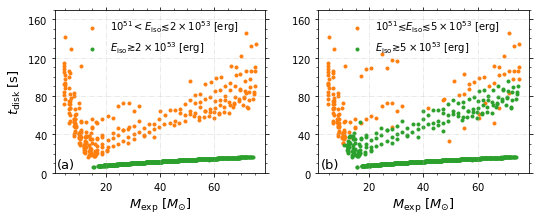

In [14]:
plt.figure(figsize = (8.5,3))
gs = GridSpec(1, 2, wspace = 0.25)

# ------------------------- For Novikov-Thorne flow -------------------------
ax1 = plt.subplot(gs[0])
coef = 0.01/0.05 

mask = (coef*dataNT['Eacc'] > 1e51) & (coef*dataNT['Eacc'] < 2e53)
plt.scatter(dataNT[mask]['Mexp'], dataNT[mask]['tff'], color = colors[1])#, z='Mbh')

mask = coef*dataNT['Eacc']  >= 2e53
plt.scatter(dataNT[mask]['Mexp'], dataNT[mask]['tff'], color = colors[2])#, z='Mbh')
 
plt.legend(['$10^{51} < E_{\\rm iso} \\lesssim 2 \\times 10^{53}$ [erg]', \
            '$E_{\\rm iso} \\gtrsim 2 \\times 10^{53}$ [erg]'], fontsize = 10)

# plt.title('NT accretion flow', pad = 10)
plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}]$')
plt.ylabel('$t_{\\rm disk}$ [s]')
# plt.ylim(0.425,1.01)
plt.grid(linestyle = '-.', alpha =.35)
plt.text(2, 5, '(a)')
plt.ylim(0., 170)
ax1.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

# ------------------------- For MAD -------------------------

ax2 = plt.subplot(gs[1])
coef = 1/0.05

mask = (coef*dataMAD['Eacc'] > 1e51) & (coef*dataMAD['Eacc'] <= 5e53)
plt.scatter(dataMAD[mask]['Mexp'], dataMAD[mask]['tff'], color = colors[1])#, z='Mbh')

mask = coef*dataMAD['Eacc']  > 5e53
plt.scatter(dataMAD[mask]['Mexp'], dataMAD[mask]['tff'], color = colors[2])#, z='Mbh')
 
plt.legend(['$10^{51} \\lesssim E_{\\rm iso} \\lesssim 5 \\times 10^{53}$ [erg]', \
            '$E_{\\rm iso} \\gtrsim 5 \\times 10^{53}$ [erg]'], fontsize = 10)
# plt.title('MA accretion flow', pad = 10)
plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}]$')
# plt.ylabel('$M_{\\rm BH}$ / $M_{\\rm exp}$')
# plt.xlim(1,68)
plt.ylim(0., 170)
plt.text(2, 5, '(b)')
plt.grid(linestyle = '-.', alpha =.35)
ax2.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

plt.savefig('./figures/time_of_disk_formation.png')

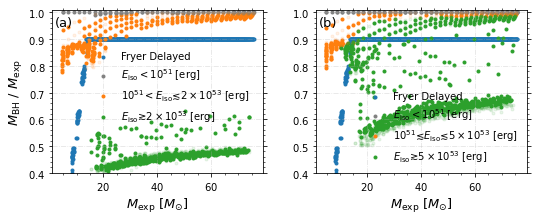

In [15]:
plt.figure(figsize = (8.5,3))
gs = GridSpec(1, 2, wspace = 0.25)

plt.subplot(gs[0])
coef = 0.01/0.05 ### fractional change

# ------------------------- calculating remnant mass using Fryer delayed prescription -------------------------
MBH_Fryer = []
for i in range(len(dataNT)):
    MBH = Fryer_delayed(dataNT.loc[i,'Mco'], dataNT.loc[i,'Mexp'])
    MBH_Fryer.append(MBH)
plt.scatter(dataNT['Mexp'], MBH_Fryer/ dataNT['Mexp'])#, z='Mbh')

# ------------------------- For the Novikov-Thorne Flow --------------------------
mask = coef*dataNT['Eacc'] <=1e51
plt.scatter(dataNT[mask]['Mexp'], dataNT[mask]['Mbh'] / dataNT[mask]['Mexp'], color = 'grey')#, z='Mbh')

mask = (coef*dataNT['Eacc'] > 1e51) & (coef*dataNT['Eacc'] < 2e53)
plt.scatter(dataNT[mask]['Mexp'], dataNT[mask]['Mbh'] / dataNT[mask]['Mexp'])#, z='Mbh')

mask = coef*dataNT['Eacc']  >= 2e53
plt.scatter(dataNT[mask]['Mexp'], dataNT[mask]['Mbh'] / dataNT[mask]['Mexp'])#, z='Mbh')
 
# ------------------------- Nonrel flow -------------------------
mask = coef*datanonrel_NT['Eacc'] <=1e51
plt.scatter(datanonrel_NT[mask]['Mexp'], datanonrel_NT[mask]['Mbh'] / datanonrel_NT[mask]['Mexp'],\
            color = 'grey')#, z='Mbh')

# mask = dataNT["abh"] >= .075
mask = (coef*datanonrel_NT['Eacc'] > 1e51) & (coef*datanonrel_NT['Eacc'] < 2e53)
plt.scatter(datanonrel_NT[mask]['Mexp'], datanonrel_NT[mask]['Mbh'] / datanonrel_NT[mask]['Mexp'],\
            color = colors[1], alpha = 0.1)#, z='Mbh')

# mask = dataNT["abh"] >=.9
mask = coef*datanonrel_NT['Eacc']  >= 2e53
plt.scatter(datanonrel_NT[mask]['Mexp'], datanonrel_NT[mask]['Mbh'] / datanonrel_NT[mask]['Mexp'],\
            color = colors[2], alpha = 0.1)#, z='Mbh')
# ----------------------------------------------------

plt.legend(['Fryer Delayed', '$E_{\\rm iso} <  10^{51}$ [erg]', '$10^{51} < E_{\\rm iso} \\lesssim 2 \\times 10^{53}$ [erg]', \
            '$E_{\\rm iso} \\gtrsim 2 \\times 10^{53}$ [erg]'], fontsize = 10, bbox_to_anchor=(0.15, 0.15, 0.65, 0.65))

# plt.title('NT accretion flow', pad = 10)
plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}]$')
plt.ylabel('$M_{\\rm BH}$ / $M_{\\rm exp}$')
plt.ylim(0.4,1.01)
plt.grid(linestyle = '-.', alpha =.35)
plt.text(2, 0.95, '(a)')


# -------------------------  MAD accretion flow  -------------------------

plt.subplot(gs[1])
coef = 1/0.05 ### fractional change

# ------------------------- Fryer prescription -------------------------
MBH_Fryer = []
for i in range(len(dataMAD)):
    MBH = Fryer_delayed(dataMAD.loc[i,'Mco'], dataMAD.loc[i,'Mexp'])
    MBH_Fryer.append(MBH)
plt.scatter(dataMAD['Mexp'], MBH_Fryer/ dataMAD['Mexp'])#, z='Mbh')

mask = coef*dataMAD['Eacc'] <=1e51
plt.scatter(dataMAD[mask]['Mexp'], dataMAD[mask]['Mbh'] / dataMAD[mask]['Mexp'], color = 'grey')#, z='Mbh')

mask = (coef*dataMAD['Eacc'] > 1e51) & (coef*dataMAD['Eacc'] <= 5e53)
plt.scatter(dataMAD[mask]['Mexp'], dataMAD[mask]['Mbh'] / dataMAD[mask]['Mexp'])#, z='Mbh')

mask = coef*dataMAD['Eacc']  > 5e53
plt.scatter(dataMAD[mask]['Mexp'], dataMAD[mask]['Mbh'] / dataMAD[mask]['Mexp'])#, z='Mbh')
 
# ----------------------- Nonrel -------------------------
mask = coef*datanonrel_MAD['Eacc'] <=1e51
plt.scatter(datanonrel_MAD[mask]['Mexp'], datanonrel_MAD[mask]['Mbh'] / datanonrel_MAD[mask]['Mexp'],\
            color = 'grey')#, z='Mbh')

# mask = dataNT["abh"] >= .075
mask = (coef*datanonrel_MAD['Eacc'] > 1e51) & (coef*datanonrel_MAD['Eacc'] < 5e53)
plt.scatter(datanonrel_MAD[mask]['Mexp'], datanonrel_MAD[mask]['Mbh'] / datanonrel_MAD[mask]['Mexp'],\
            color = colors[1], alpha = 0.1)#, z='Mbh')

# mask = dataNT["abh"] >=.9
mask = coef*datanonrel_MAD['Eacc']  >= 5e53
plt.scatter(datanonrel_MAD[mask]['Mexp'], datanonrel_MAD[mask]['Mbh'] / datanonrel_MAD[mask]['Mexp'],\
            color = colors[2], alpha = 0.1)#, z='Mbh')
# ----------------------------------------------------

plt.legend(['Fryer Delayed', '$E_{\\rm iso} <  10^{51}$ [erg]', '$10^{51} \\lesssim E_{\\rm iso} \\lesssim 5 \\times 10^{53}$ [erg]', \
            '$E_{\\rm iso} \\gtrsim 5 \\times 10^{53}$ [erg]'], fontsize = 10, loc = 'lower right')
# plt.title('MA accretion flow', pad = 10)
plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}]$')
# plt.ylabel('$M_{\\rm BH}$ / $M_{\\rm exp}$')
# plt.xlim(1,68)
plt.ylim(0.4,1.01)
plt.text(2, 0.95, '(b)')
plt.grid(linestyle = '-.', alpha =.35)

plt.savefig('./figures/Mexp_MBH_ratio.png')

In [16]:
def transform_spin(x, y):
    df = pd.DataFrame()
    
    df["x"] = x
    df["y"] = y
    
    df["sqrt(xy)"] = np.sqrt(df['x'] * df['y'])
    df["sqrt(x)"] = np.sqrt(df['x'])
    df["sqrt(y)"] = np.sqrt(df['y'])

    df["sqrt(x)x"] = np.sqrt(df['x']) * df['x']
    df["sqrt(y)x"] = np.sqrt(df['y'])  * df['x']

    df["sqrt(x)y"] = np.sqrt(df['x'])  * df['y']
    df["sqrt(y)y"] = np.sqrt(df['y'])  * df['y']
    df["square(x)"] = df['x'] * df['x']
    df["square(y)"] = df['y'] * df['y']

    df["xy"] = df['x'] * df['y']
    df["xxy"] = df['x'] * df['x'] * df['y']
    df["xyy"] = df['x'] * df['y'] * df['y']
    
    features = ["sqrt(xy)", "sqrt(x)", "sqrt(y)", "xy", "x", "y"]

    return df[features]

Max abh for MAD =  0.6006


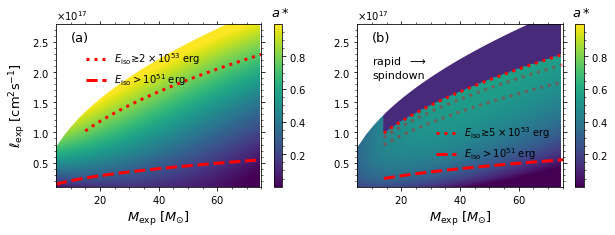

In [17]:
plt.figure(figsize = (10,3))
gs = GridSpec(1, 2, wspace = 0.175)

# ------ For later use ---------
x = "Mexp"
y = "AMexp"
z = "abh"
msun = 1.989e33
features = ["sqrt(xy)", "sqrt(x)", "sqrt(y)", "xy", "x", "y"]
result = []

# ------------------------- Novikov - Thorne flow -------------------------
plt.subplot(gs[0])
mask = dataNT['abh'] < 1
df_temp = dataNT[mask].copy()
df_temp[y] = (dataNT['AMexp'] / dataNT['Mexp'] / msun / 1e14).astype(float)

df_temp["sqrt(xy)"] = np.sqrt(df_temp[x] * df_temp[y])
df_temp["sqrt(x)"] = np.sqrt(df_temp[x])
df_temp["sqrt(y)"] = np.sqrt(df_temp[y])

df_temp["xy"] = df_temp[x] * df_temp[y]
df_temp["x"] = df_temp[x]
df_temp["y"] = df_temp[y]

min_ = np.min(df_temp[y])
max_ = np.max(dataNT[y]/ dataNT['Mexp'] / msun / 1e14)

x_ = np.arange(5,75,.5)
y_ = np.linspace((min_), (max_), len(x_))
X,Y = np.meshgrid(x_,y_)

# -------- Performing fit ---------
model_linear = Ridge()
model_linear.fit(df_temp[features], df_temp[z])
Z1 = np.zeros(X.shape)
for i in range(len(Z1)):
    Z1[i] = model_linear.predict(transform_spin(X[:, i],Y[:, i]))
    Z1[i][Z1[i] < 0] = 1e-3
    Z1[i][Z1[i] > 0.9994] = 0.9994
    y_temp = (1.25e33*X[:, i])**(1/2)  / 1e14
    Z1[i][(Y[:, i] > y_temp) & (X[:,i] >= 15.)] = 0.9994
result.append(list(zip(features,model_linear.coef_)))
    
min_ = np.min(df_temp[y]) * 1e14
max_ = np.max(dataNT[y]/ dataNT['Mexp'] / msun / 1e14) * 1e14
# x_ = np.arange(5,75,.005)
# y = np.logspace(np.log10(min_), np.log10(max_), len(x))
vmin = np.min(Z1)
vmax = np.max(Z1)
y_ = np.linspace(min_, max_, len(x_))
plt.imshow(Z1.T, extent=[x_.min(), x_.max(), y_.min(), y_.max()], \
           cmap='viridis', origin='lower', aspect='auto')#, interpolation="gaussian")
cb = plt.colorbar()
cb.ax.set_title('$\,\, a*$', pad = 7)
  
# ------------------------- Plotting the lines that sketch the GRB energy -------------------------
x_ = np.arange(15,80,2.5)
y_ = (7e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':')

x_ = np.arange(5,80,2.5)
y_ = (4e31*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = '--')

# ------------------------- The fill the remaining region white -------------------------
y_ = (1.25e33*x_)**(1/2)
plt.fill_between(x_, y_, np.max(y_), color='white')#, alpha=0.3)


plt.text(10, 2.5e17, '(a)')
plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}$]')
plt.ylabel('$\\ell_{\\rm exp}  \,\, [{\\rm cm}^2 {\\rm s}^{-1}]$')
plt.legend(['$E_{\\rm iso} \\gtrsim 2 \\times 10^{53}$ erg', '$E_{\\rm iso} >  10^{51}$ erg'], \
                                      bbox_to_anchor=[0.75, 0.72], loc = 'center right', fontsize=10)
# plt.yscale('log')
# plt.title('NT accretion flow')
plt.xlim(5,75)
plt.ylim(0.1e17,2.8*1e17)
# plt.xscale('log')


# ---------------------------------  MAD accretion flow ------------------------------

plt.subplot(gs[1])
mask = dataMAD['abh'] > 0.12  # The ones with smaller values all accumulte around 0.1
df_temp = dataMAD[mask].copy()
df_temp[y] = (df_temp['AMexp'] / df_temp['Mexp'] / msun / 1e14).astype(float)

df_temp["sqrt(xy)"] = np.sqrt(df_temp[x] * df_temp[y])
df_temp["sqrt(x)"] = np.sqrt(df_temp[x])
df_temp["sqrt(y)"] = np.sqrt(df_temp[y])

df_temp["xy"] = df_temp[x] * df_temp[y]
df_temp["x"] = df_temp[x]
df_temp["y"] = df_temp[y]

min_ = np.min(df_temp[y])
max_ = np.max(dataMAD[y]/ dataMAD['Mexp'] / msun / 1e14)
x_ = np.arange(5,75,.5)
y_ = np.linspace((min_), (max_), len(x_))
X,Y = np.meshgrid(x_,y_)

# ------------------------- Performing fit -------------------------
print('Max abh for MAD = ', max(dataMAD['abh']))
model_linear = Ridge()
model_linear.fit(df_temp[features], df_temp[z])

Z1 = np.zeros(X.shape)
for i in range(len(Z1)):
    Z1[i] = model_linear.predict(transform_spin(X[:, i],Y[:, i]))
    Z1[i][Z1[i] < 0] = 1e-5
    Z1[i][Z1[i] > max(dataMAD['abh'])] = max(dataMAD['abh'])
    y_temp = (7e32*X[:, i])**(1/2)  / 1e14
    Z1[i][(Y[:, i] > y_temp) & (X[:,i] >= 14.)] = 0.12

result.append(list(zip(features,model_linear.coef_)))
    
min_ = np.min(df_temp[y]) * 1e14
max_ = np.max(dataMAD[y]/ dataMAD['Mexp'] / msun / 1e14) * 1e14
# x_ = np.arange(5,75,.005)
# y = np.logspace(np.log10(min_), np.log10(max_), len(x))
y_ = np.linspace(min_, max_, len(x_))
plt.imshow(Z1.T, extent=[x_.min(), x_.max(), y_.min(), y_.max()], \
           cmap='viridis', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)#, interpolation="gaussian")
cb = plt.colorbar()
cb.ax.set_title('$\,\, a*$', pad = 7)
  

# ------------------------- GRB energy liens -------------------------
x_ = np.arange(14,80,2.5)
y_ = (7e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':')

y_ = (4e31*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = '--')

# ------------------------- And a few more lines -------------------------
x_ = np.arange(14,80,2.5)
y_ = (4.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':', alpha = 0.2)
# y_ = (5.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':', alpha = 0.2)
y_ = (6e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':', alpha = 0.2)
# y_ = (6.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':', alpha = 0.2)

# ------------------------- Fill with white color -------------------------
x_ = np.arange(5,80,2.5)
y_ = (1.25e33*x_)**(1/2)
plt.fill_between(x_, y_, np.max(y_), color='white')#, alpha=0.3)

plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}$]')
# plt.ylabel('$\\ell_{\\rm exp}  \,\, [{\\rm gcm}^2 {\\rm s}^{-1}]$')
plt.legend(['$E_{\\rm iso} \\gtrsim 5 \\times 10^{53}$ erg', '$E_{\\rm iso} >  10^{51}$ erg'], \
                                    bbox_to_anchor=[.985, 0.1], loc = 'lower right', fontsize=10)
# plt.yscale('log')
# plt.text(50, 1.75e17, '$\\downarrow$', fontsize = 20)
plt.xlim(5,75)
plt.ylim(0.1e17,2.8*1e17)
plt.text(10, 2.5e17, '(b)')
plt.text(10, 1.9e17, 'rapid  $\\longrightarrow$ \nspindown', fontsize = 11)
# plt.xscale('log')
plt.savefig('./figures/2D_hist_spin.png')

### The below plots the acutal data on which the above fits were performed

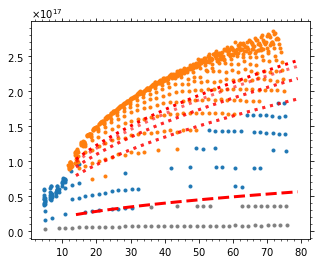

In [18]:
#  ------ For the case of MAD / similary can also plot for the NTD state-------

# msun = 1.989e33

# mask = dataMAD["abh"] >= .12
mask = coef*dataMAD['Eacc'] <=1e51
plt.scatter(dataMAD[mask]['Mexp'], dataMAD[mask]['AMexp'] / (dataMAD[mask]['Mexp']*msun), color = 'grey')#, z='Mbh')

# mask = dataMAD["abh"] <= .12
mask = (coef*dataMAD['Eacc'] > 1e51) & (coef*dataMAD['Eacc'] <= 5e53)
plt.scatter(dataMAD[mask]['Mexp'], dataMAD[mask]['AMexp'] / (dataMAD[mask]['Mexp']*msun))#, z='Mbh')

mask = dataMAD["abh"] <=.12
mask = coef*dataMAD['Eacc']  > 6e53
plt.scatter(dataMAD[mask]['Mexp'], dataMAD[mask]['AMexp'] / (dataMAD[mask]['Mexp']*msun))#, z='Mbh')
 
x_ = np.arange(14,80,2.5)
y_ = (7.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':')


y_ = (4e31*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = '--')

x_ = np.arange(14,80,2.5)
y_ = (4.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':', alpha = 0.6)
# y_ = (5.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':', alpha = 0.6)
y_ = (6e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':', alpha = 0.6)
# y_ = (6.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':', alpha = 0.6)
y_ = (7e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':', alpha = 0.6)

### 2D histograms for MBH

In [19]:
def transform_MBH(x, y):
    df = pd.DataFrame()
    
    df["x"] = x
    df["y"] = y
    
    df["sqrt(xy)"] = np.sqrt(df['x'] * df['y'])
    df["sqrt(x)"] = np.sqrt(df['x'])
    df["sqrt(y)"] = np.sqrt(df['y'])

    df["sqrt(x)x"] = np.sqrt(df['x']) * df['x']
    df["sqrt(y)x"] = np.sqrt(df['y'])  * df['x']
    df["xy"] = df['x'] * df['y']
    
    features = ["sqrt(xy)", "sqrt(x)", "sqrt(y)", "x", "y"]

    return df[features]

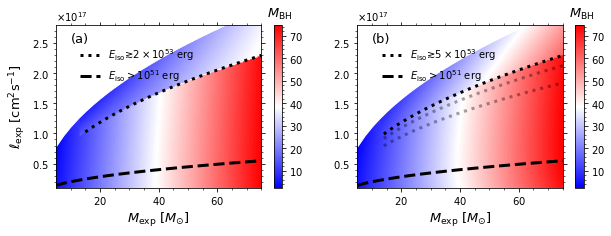

In [20]:
plt.figure(figsize = (10,3))
gs = GridSpec(1, 2, wspace = 0.175)

# ----- For later use ----
x = "Mexp"
y = "AMexp"
z = "Mbh"   
msun = 1.989e33
features = ["sqrt(xy)", "sqrt(x)", "sqrt(y)", "x", "y"]
result = []

# ----------------------------- For Novilov-Thorne flow -----------------------------
plt.subplot(gs[0])
mask = dataNT['abh'] <= 0.9 #(for the upper branch)
df_temp = dataNT[mask].copy()
df_temp[y] = (df_temp['AMexp'] / df_temp['Mexp'] / msun / 1e14).astype(float)

df_temp["sqrt(xy)"] = np.sqrt(df_temp[x] * df_temp[y])
df_temp["sqrt(x)"] = np.sqrt(df_temp[x])
df_temp["sqrt(y)"] = np.sqrt(df_temp[y])
df_temp["x"] = df_temp[x]
df_temp["y"] = df_temp[y]

# ----------------------------- performing fit -----------------------------
model_linear = Ridge()
model_linear.fit(df_temp[features], df_temp[z])
min_ = np.min(dataNT[y]/ dataNT['Mexp'] / msun / 1e14)
max_ = np.max(dataNT[y]/ dataNT['Mexp'] / msun / 1e14)
x_ = np.arange(5,75,.5)
y_ = np.linspace((min_), (max_), len(x_))
X,Y = np.meshgrid(x_,y_)

Z2 = np.zeros(X.shape)
for i in range(len(Z2)):
    Z2[i] = model_linear.predict(transform_MBH(X[:, i],Y[:, i]))
result.append(list(zip(features,model_linear.coef_)))


# -------------------------------------
mask = dataNT['abh'] > 0.9  #(for the lower branch)
df_temp = dataNT[mask].copy()
df_temp[y] = (df_temp['AMexp'] / df_temp['Mexp'] / msun / 1e14).astype(float)

df_temp["sqrt(xy)"] = np.sqrt(df_temp[x] * df_temp[y])
df_temp["sqrt(x)"] = np.sqrt(df_temp[x])
df_temp["sqrt(y)"] = np.sqrt(df_temp[y])
df_temp["x"] = df_temp[x]
df_temp["y"] = df_temp[y]

model_linear = Ridge()
model_linear.fit(df_temp[features], df_temp[z])

Z3 = np.zeros(X.shape)
for i in range(len(Z3)):
    Z3[i] = model_linear.predict(transform_MBH(X[:, i],Y[:, i]))
result.append(list(zip(features,model_linear.coef_)))

for i in range(len(Z2)):
    y_temp1 = (7e32*X[:, i])**(1/2)  / 1e14
    y_temp2 = (1.25e33*X[:, i])**(1/2)  / 1e14
    Z2[i][Z2[i] < 2.5] = 2.5
    if X[0,i] > 12.5:
        # Mixing the lower brach values with the upper branch ones
        Z2[i][(Y[:, i] > y_temp1) & (Y[:, i] < y_temp2)] = Z3[i][(Y[:, i] > y_temp1) & (Y[:, i] < y_temp2)]

df_temp = dataNT.copy()
df_temp[y] = (dataNT['AMexp'] / dataNT['Mexp'] / msun / 1e14).astype(float)

min_ = np.min(df_temp[y]) * 1e14
max_ = np.max(df_temp[y]) * 1e14
x_ = np.arange(5,75,.005)
# y = np.logspace(np.log10(min_), np.log10(max_), len(x))
y_ = np.linspace(min_, max_, len(x))
plt.imshow(Z2.T, extent=[x_.min(), x_.max(), y_.min(), y_.max()], \
           cmap='bwr', origin='lower', aspect='auto')#, interpolation="gaussian")
cb = plt.colorbar()
cb.ax.set_title('$\,\, M_{\\rm BH}$', pad = 7)
  

# ----------------------------- Plotting some GRB energy lines -----------------------------
x_ = np.arange(15,85,2.5)
y_ = (7e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'k', linestyle = ':')

x_ = np.arange(5,85,2.5)
y_ = (4e31*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'k', linestyle = '--')

x_ = np.arange(5,85,2.5)
y_ = (1.25e33*x_)**(1/2)
plt.fill_between(x_, y_, np.max(y_), color='white')#, alpha=0.3)

    
plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}$]')
plt.ylabel('$\\ell_{\\rm exp}  \,\, [{\\rm cm}^2 {\\rm s}^{-1}]$')
plt.legend(['$E_{\\rm iso} \\gtrsim 2 \\times 10^{53}$ erg', '$E_{\\rm iso} >  10^{51}$ erg'],\
                              bbox_to_anchor=[.72, 0.75], loc = 'center right', fontsize=10)

plt.text(10, 2.51e17, '(a)')
# plt.yscale('log')
plt.xlim(5,75)
plt.ylim(0.1e17,2.8*1e17)
# plt.xscale('log')


#--------------------------------------- MAD flow ----------------------------------
plt.subplot(gs[1])
mask = dataMAD['abh'] > 0.12 # Upper branch
df_temp = dataMAD[mask].copy()
df_temp[y] = (df_temp['AMexp'] / df_temp['Mexp'] / msun / 1e14).astype(float)

df_temp["sqrt(xy)"] = np.sqrt(df_temp[x] * df_temp[y])
df_temp["sqrt(x)"] = np.sqrt(df_temp[x])
df_temp["sqrt(y)"] = np.sqrt(df_temp[y])
df_temp["x"] = df_temp[x]
df_temp["y"] = df_temp[y]

min_ = np.min(dataMAD[y]/ dataMAD['Mexp'] / msun / 1e14)
max_ = np.max(dataMAD[y]/ dataMAD['Mexp'] / msun / 1e14)
x_ = np.arange(5,75,.5)
y_ = np.linspace((min_), (max_), len(x_))
X,Y = np.meshgrid(x_,y_)

# ----------------------------- Performing fit -----------------------------
model_linear = Ridge()
model_linear.fit(df_temp[features], df_temp[z])
Z2 = np.zeros(X.shape)
for i in range(len(Z2)):
    Z2[i] = model_linear.predict(transform_MBH(X[:, i],Y[:, i]))
result.append(list(zip(features,model_linear.coef_)))


# -------------------------------------

mask = dataMAD['abh'] < 0.12 # Lower branch
df_temp = dataMAD[mask].copy()
df_temp[y] = (df_temp['AMexp'] / df_temp['Mexp'] / msun / 1e14).astype(float)

df_temp["sqrt(xy)"] = np.sqrt(df_temp[x] * df_temp[y])
df_temp["sqrt(x)"] = np.sqrt(df_temp[x])
df_temp["sqrt(y)"] = np.sqrt(df_temp[y])
df_temp["x"] = df_temp[x]
df_temp["y"] = df_temp[y]

# ------------------------- Performing fit ---------------------------
model_linear = Ridge()
model_linear.fit(df_temp[features], df_temp[z])

Z3 = np.zeros(X.shape)
for i in range(len(Z3)):
    Z3[i] = model_linear.predict(transform_MBH(X[:, i],Y[:, i]))
result.append(list(zip(features,model_linear.coef_)))

for i in range(len(Z2)):
    y_temp1 = (7e32*X[:, i])**(1/2)  / 1e14
    y_temp2 = (1.3e33*X[:, i])**(1/2)  / 1e14
    Z2[i][Z2[i] < 2.5] = 2.5
    if X[0,i] > 12.5:
        # Putting the two branch values together
        Z2[i][(Y[:, i] > y_temp1) & (Y[:, i] < y_temp2)] = Z3[i][(Y[:, i] > y_temp1) & (Y[:, i] < y_temp2)]
# #     Z2[i][Y[:, i] > y_temp2] = (np.min(Z2) + np.max(Z2))/2  # this gives 39.2 which is the white color bit


df_temp = dataMAD.copy()
df_temp[y] = (dataMAD['AMexp'] / dataMAD['Mexp'] / msun / 1e14).astype(float)

min_ = np.min(df_temp[y]) * 1e14
max_ = np.max(df_temp[y]) * 1e14
x_ = np.arange(5,75,.005)
# y = np.logspace(np.log10(min_), np.log10(max_), len(x))
y_ = np.linspace(min_, max_, len(x))
plt.imshow(Z2.T, extent=[x_.min(), x_.max(), y_.min(), y_.max()], \
           cmap='bwr', origin='lower', aspect='auto')#, interpolation="gaussian")
cb = plt.colorbar()
cb.ax.set_title('$\,\, M_{\\rm BH}$', pad = 7)
  
# ----------------------------- Plotting some GRB energy liens -----------------------------
x_ = np.arange(14,85,2.5)
y_ = (7e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'k', linestyle = ':')

x_ = np.arange(5,85,2.5)
y_ = (4e31*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'k', linestyle = '--')

x_ = np.arange(14,80,2.5)
y_ = (4.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'k', linestyle = ':', alpha = 0.2)
# y_ = (5.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'k', linestyle = ':', alpha = 0.2)
y_ = (6e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'k', linestyle = ':', alpha = 0.2)
# y_ = (6.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'k', linestyle = ':', alpha = 0.2)

# ----------------------------- Filling the unneeded region with white color ---------------------------
x_ = np.arange(5,85,2.5)
y_ = (1.25e33*x_)**(1/2)
plt.fill_between(x_, y_, np.max(y_), color='white')#, alpha=0.3)


plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}$]')
# plt.ylabel('$\\ell_{\\rm exp}  \,\, [{\\rm gcm}^2 {\\rm s}^{-1}]$')
plt.legend(['$E_{\\rm iso} \\gtrsim 5 \\times 10^{53}$ erg', '$E_{\\rm iso} >  10^{51}$ erg'],\
                              bbox_to_anchor=[.72, 0.75], loc = 'center right', fontsize=10)

plt.text(10, 2.51e17, '(b)')
plt.xlim(5,75)
plt.ylim(0.1e17,2.8*1e17)
# plt.xscale('log')

plt.savefig('./figures/2D_hist_MBH.png')

## Plotting Domain of validity for black hole helium star binary

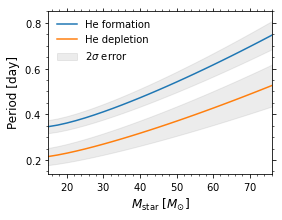

In [15]:
rsun = 696340 *1e5  #in cm
day_sec = 3600*24
msun = 1.989e33
x = np.arange(10,80,2.5)

plt.figure(figsize = (4,3))

y = (2e99*x)**(1/2)
R = 0.028*x + 1#.85
j = 1.25*(9e32*x)**(1/2)

mask = dataNT["abh"] > .9
rg = dataNT[mask]['AMfinal_He_form'] / (dataNT[mask]['MHe_form']*msun) / (dataNT[mask]['R_He_form']*rsun)**2 \
                / (dataNT[mask]['Omega_mean_He_form'])
rgmean = np.mean(rg)
rgstd = np.std(rg)


P = rgmean * 2*np.pi * (R*rsun)**2 / j
plt.plot(x, P / day_sec, label='He formation')

P_upper = (rgmean + 2*rgstd) * 2 * np.pi * (R * rsun)**2 / j
P_lower = (rgmean - 2*rgstd) * 2 * np.pi * (R * rsun)**2 / j
plt.fill_between(x, P_lower / day_sec, P_upper / day_sec, color='gray', alpha=0.15)

annotation_text = "smaller periods lead to \nstrong mass loss at collapse"
arrow_props = dict(color='black', arrowstyle='<-', linewidth = 1.5)

# --------------------------------- 2nd plot -----------------------------
# y = (2e99*x)**(1/2)
R = 0.028*x + .85
j = (8e32*x)**(1/2)
rg = dataNT[mask]['AMfinal_He_dep'] / (dataNT[mask]['MHe_dep']*msun) / (dataNT[mask]['R_He_dep']*rsun)**2 \
                / (dataNT[mask]['Omega_mean_He_dep'])
rgmean = np.mean(rg)
rgstd = np.std(rg)

P = rgmean * 2*np.pi * (R*rsun)**2 / j
plt.plot(x, P / day_sec, label='He depletion')

P_upper = (rgmean + 2*rgstd) * 2 * np.pi * (R * rsun)**2 / j
P_lower = (rgmean - 2*rgstd) * 2 * np.pi * (R * rsun)**2 / j
plt.fill_between(x, P_lower / day_sec, P_upper / day_sec, color='gray', alpha=0.15, label='2$\\sigma$ error')


plt.legend(loc = 'upper left', fontsize = 10)
plt.xlim(15,76)
plt.locator_params(axis='y', nbins=6)

plt.xlabel('$M_{\\rm star} \,\, [M_{\\odot}]$', fontsize = 12)
plt.ylabel('Period [day]', fontsize = 12)
plt.savefig('./MHe_vs_period.png')

## Additional (supplementry) figures not presented in the paper

$r_g^2$ =  0.041428571798603896
std =  0.0036096373546498943


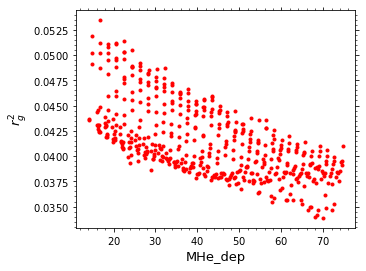

In [128]:
### Calculating radius of gyration (sample exercise)

mask = dataNT["abh"] > .9
msun = 1.989e33
rsun = rsun = 696340 *1e5  #in cm
# note that I do not know omega so have assuemd a period of 0.5 ----- SAVE THIS IN CODE or maybe save rg itself
rg = dataNT[mask]['AMfinal_He_dep'] / (dataNT[mask]['MHe_dep']*msun) / (dataNT[mask]['R_He_dep']*rsun)**2 \
                / (dataNT[mask]['Omega_mean_He_dep'])

# core_he  = data[mask]['MHe_dep'] /  data[mask]['MHe_form']
plt.scatter(dataNT[mask]['MHe_dep'], rg, color = 'r')

plt.xlabel('MHe_dep')
plt.ylabel('$r_g^2$')
rgmean = np.mean(rg)
rgstd = np.std(rg)
print('$r_g^2$ = ', np.mean(rg))
print('std = ',np.std(rg))

Text(0, 0.5, 'Rexp')

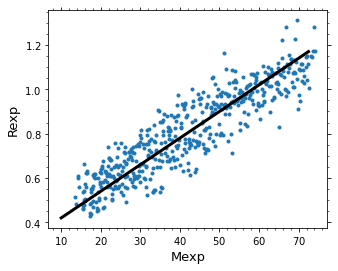

In [129]:
### mass radius relation
mask = dataNT["abh"] > 0.9
plt.scatter(dataNT[mask]['Mexp'], dataNT[mask]['Rexp'])#, z='Mbh')
# plt.ylim(1,5)

x = np.arange(10,75,2.5)
# y = (2e99*x)**(1/2)
# y = (0.85/60)*(x - 20) + 0.65
y = 0.012*x + .3
plt.plot(x, y, linewidth = 3, color = 'k')
# y = (0.132*x)**0.5
# plt.plot(x, y, linewidth = 3, color = 'r')
plt.xlabel('Mexp')
plt.ylabel('Rexp')

### Below shows plots in 3D

In [21]:
x = "Mexp"
y = "AMexp"
z = "Mbh"
data = dataMAD.copy()

In [22]:
# plotting data
mask = (data['abh'] < 1)#.125) & (data['abh'] > .115)
data[y] = (data['AMexp'] / data['Mexp'] / msun / 1e14).astype(float)
px.scatter_3d(data[mask], x='Mexp', y='AMexp', z = data[mask][z])

In [23]:
msun = 1.989e33
df_temp = data[mask].copy()
df_temp[y] = (df_temp['AMexp'] / df_temp['Mexp'] / msun/1e14)

In [24]:
df_temp["sqrt(xy)"] = np.sqrt(df_temp[x] * df_temp[y])
df_temp["sqrt(x)"] = np.sqrt(df_temp[x])
df_temp["sqrt(y)"] = np.sqrt(df_temp[y])

df_temp["xy"] = df_temp[x] * df_temp[y]
df_temp["x"] = df_temp[x]
df_temp["y"] = df_temp[y]

In [25]:
features = ["sqrt(xy)", "sqrt(x)", "sqrt(y)", "x", "y", "xy"]
target = z

In [31]:
model_linear = Ridge()
model_linear.fit(df_temp[features], df_temp[z])
model_linear.score(df_temp[features], df_temp[z])

0.8649008649660517

In [27]:
prediction = model_linear.predict(df_temp[features])

In [28]:
#Actual data
px.scatter_3d(df_temp, x='Mexp', y='AMexp', z = df_temp[z])

In [29]:
#  fit 
px.scatter_3d(df_temp, x='Mexp', y='AMexp', z = prediction)

In [30]:
#Shows residual error
px.scatter_3d(df_temp, x='Mexp', y='AMexp', z = prediction - df_temp[z])  


In [32]:
### We note that to minize residual error, the actual fit is done in two steps.